## Import packages

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#for regression
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Data Preparation

#### Import Data

In [2]:
df = pd.read_csv('data/googleplaystore.csv')

In [3]:
#overview of the data
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


#### Handling Missing Observations 

In [4]:
#Count the number of missing observations per column
df.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [5]:
#Drop null values from the data

data = df.dropna()
#Check if there are any missing obsrevations in the data
data.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

#### Variable conversion and formatting 

##### Size Variable

In [6]:
#extract the numerical value of the size
data['size1'] = data.Size.str.extract('(\d+)')
#Convert type of the size attribute
data['size1'] = pd.to_numeric(data['size1'])
#Get the symbol of the size
data['sym'] = data.Size.str.replace('\d+', '')
data['sym'] = data.sym.str.replace('[^\w\s]','')
#Multiply the size attribute with 1000 if the size is in MB


data['Size'] = np.where((data['sym']=='M'),data['size1']*100,data['size1'])
#Drop the aditional columns
data = data.drop(['size1', 'sym'], axis = 1)

##### Reviews variable

In [7]:
#Convert the reviews attribute to numeric

data["Reviews"] = pd.to_numeric(data['Reviews'])

##### Installs Variable

In [8]:
#Remove + from the variable and convert to integer

data['Installs'] = data['Installs'].str.replace('[^\w\s]','')
#Convert to integer
data['Installs'] = [int(item) for item in data['Installs']] 

##### Price Variable

In [9]:
#Remove $ from the variable and convert to numeric
data['Price'] = pd.to_numeric(data['Price'].str.replace('$',''))

### Sanity Checks

##### Check for Average Rating

In [10]:
data['Rating'].unique()

array([4.1, 3.9, 4.7, 4.5, 4.3, 4.4, 3.8, 4.2, 4.6, 4. , 4.8, 4.9, 3.6,
       3.7, 3.2, 3.3, 3.4, 3.5, 3.1, 5. , 2.6, 3. , 1.9, 2.5, 2.8, 2.7,
       1. , 2.9, 2.3, 2.2, 1.7, 2. , 1.8, 2.4, 1.6, 2.1, 1.4, 1.5, 1.2])

In [11]:
#Drop rows whose rating is greater than 5.0 or less than 1
data = data[(data['Rating'] >= 0) & (data['Rating'] <= 5 )].copy()

In [12]:
#Check to confirm whether there are anomalies
data[['Rating']].describe()

,Rating
count,9360.000000
mean,4.191838
std,0.515263
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


##### Check for number of reviews and installs

In [13]:
#Drop rows where reviews are more than installs
data = data[data['Reviews'] <= data['Installs']].copy()

##### Check for Type and Price

In [14]:
#Drop obsrevations where the type is free but price is greater than 0
data = data.dropna()
data = data.drop(data[(data['Type'] == 'Free') & (data['Price'] != 0.0)].index).copy()

### Univariate Analysis

##### Boxplot for Price

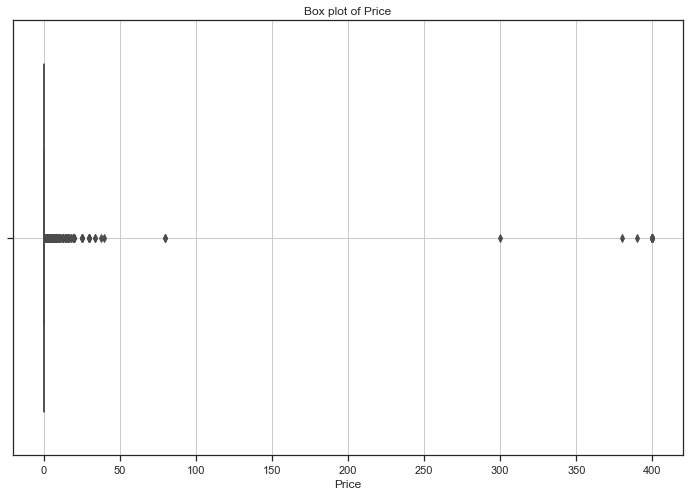

In [15]:
sns.set_theme(style="ticks")
plt.rcParams['figure.figsize'] = [12,8]
sns.boxplot(x = 'Price', data = data)
plt.title('Box plot of Price')
plt.grid()

##### Are there any outliers?

> From the plot above, we note that there are some outliers in the data especially for apps whose prices are above 200 i.e., we note that about 4 apps have prices of above $200.

##### Boxplot for Reviews

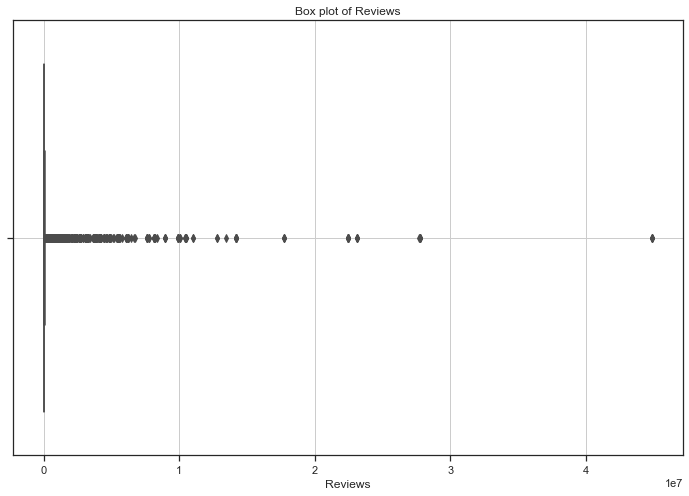

In [16]:
sns.set_theme(style="ticks")
plt.rcParams['figure.figsize'] = [12,8]
sns.boxplot(x = 'Reviews', data = data)
plt.title('Box plot of Reviews')
plt.grid()

> From the preceding plot, we note that some apps have over 50,000,000 reviews with the highest reviews for an app being about 78 million. However, while such amount of reviews are large, some of the appas have high number of installs which might make sense if these reviews are associated with high number of installs hence could not be outliers.

##### Histogram of Rating

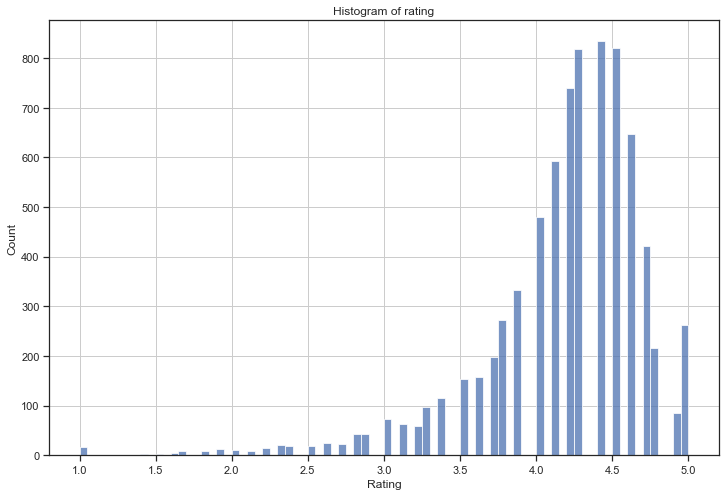

In [17]:
plt.rcParams['figure.figsize'] = [12,8]
sns.histplot(x = 'Rating', data = data)
plt.title("Histogram of rating")
plt.grid()
plt.show()

> As shown in the histogram above, most of the ratings are distributed towards higher ratings of between 4.0 and 4.6

##### Histogram of Size

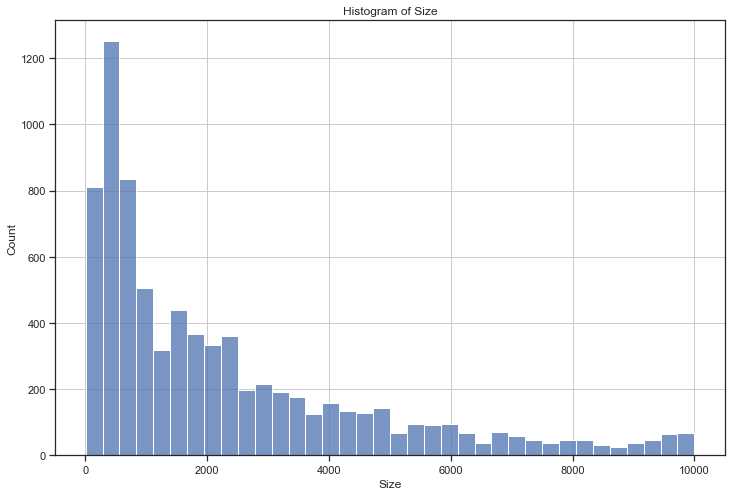

In [18]:
plt.rcParams['figure.figsize'] = [12,8]
sns.histplot(x = 'Size', data = data)
plt.title("Histogram of Size")
plt.grid()
plt.show()

> Most of the apps as noted above have a size fo between 200kbs and 600 kbs with most apps having a size of 300kbs. Overall, the size of the apps is skewed to the right.

### Outlier Treatment

##### Checking apps whose prices are above $200

In [19]:
data[data['Price'] >= 200]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4197,most expensive app (H),FAMILY,4.3,6,100.0,100,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up
4362,💎 I'm rich,LIFESTYLE,3.8,718,2600.0,10000,Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,700.0,10000,Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
5351,I am rich,LIFESTYLE,3.8,3547,100.0,100000,Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
5354,I am Rich Plus,FAMILY,4.0,856,800.0,10000,Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
5355,I am rich VIP,LIFESTYLE,3.8,411,200.0,10000,Paid,299.99,Everyone,Lifestyle,"July 21, 2018",1.1.1,4.3 and up
5356,I Am Rich Premium,FINANCE,4.1,1867,400.0,50000,Paid,399.99,Everyone,Finance,"November 12, 2017",1.6,4.0 and up
5357,I am extremely Rich,LIFESTYLE,2.9,41,200.0,1000,Paid,379.99,Everyone,Lifestyle,"July 1, 2018",1.0,4.0 and up
5358,I am Rich!,FINANCE,3.8,93,2200.0,1000,Paid,399.99,Everyone,Finance,"December 11, 2017",1.0,4.1 and up
5359,I am rich(premium),FINANCE,3.5,472,965.0,5000,Paid,399.99,Everyone,Finance,"May 1, 2017",3.4,4.4 and up


> Examining the apps whose price is greater than $200, one would argue that such a price is high.

##### Drop apps whose price is greater than $200

In [20]:
data = data[data['Price'] <= 200].copy()

##### Drop apps whose reviews are more than 2 million

In [21]:
data = data[data['Reviews'] <= 2000000].copy()

##### Compute percentiles for the number of installs

In [22]:
perc = [10, 25, 50, 70, 90, 95, 99]

for i in perc:
    perce = np.percentile(data.Installs,i)
    print (str(i)+"th"+" Percentile value of installs =",perce)

10th Percentile value of installs = 1000.0
25th Percentile value of installs = 10000.0
50th Percentile value of installs = 100000.0
70th Percentile value of installs = 1000000.0
90th Percentile value of installs = 10000000.0
95th Percentile value of installs = 10000000.0
99th Percentile value of installs = 50000000.0


> Our threshold for outliers in installs based on evidence from the percentiles would be 95th percentile value i.e., 100 million

In [23]:
#Exclude the outliers from the data
data = data[data['Installs'] <= 10000000].copy()

### Bivariate Analysis

>  Let’s look at how the available predictors relate to the variable of interest, i.e., our target variable rating. Make scatter plots (for numeric features) and box plots (for character features) to assess the relations between rating and the other features.

##### Scatterplot of Rating vs Price

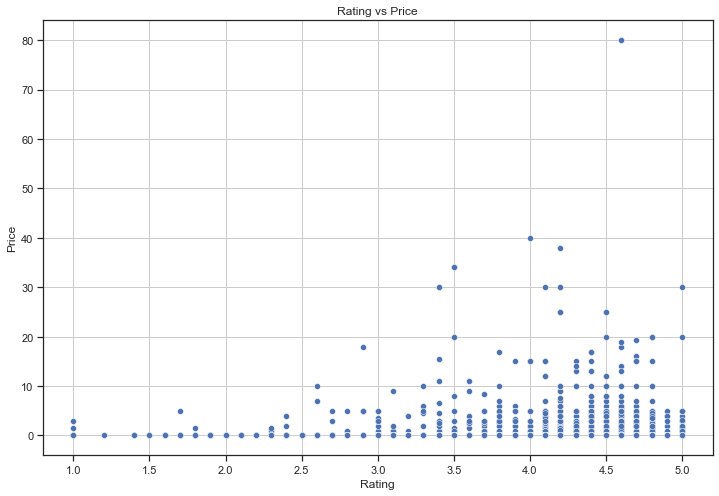

In [24]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.scatterplot(x = 'Rating', y = 'Price', data = data)
plt.grid()
plt.title('Rating vs Price')
plt.show()

> Overall, we note that apps with higher ratings i.e., 3.0 and above tend to have higher prices compared to those whose rating is 3.0 and below

##### Rating vs Size

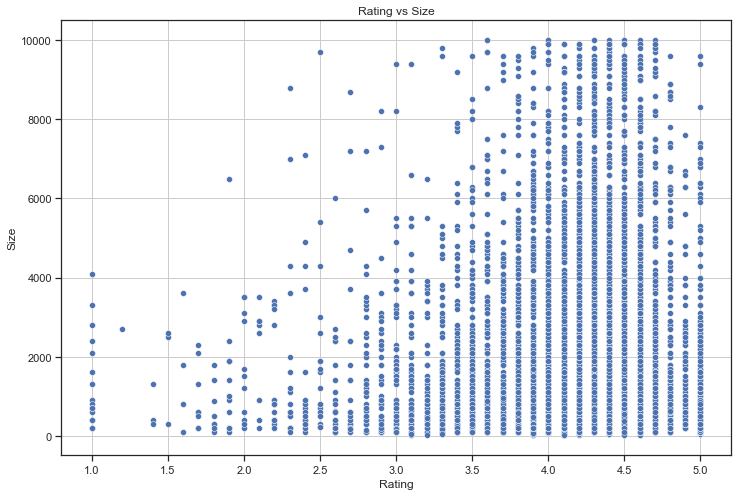

In [25]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.scatterplot(x = 'Rating', y = 'Size', data = data)
plt.grid()
plt.title('Rating vs Size')
plt.show()

> Heavier apps as shown from the plot above have higher rating i.e., they are rated better

##### Ratings vs Reviews

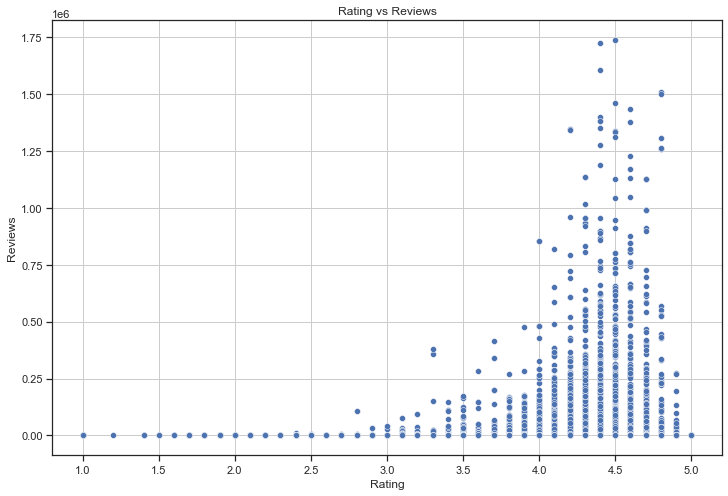

In [26]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.scatterplot(x = 'Rating', y = 'Reviews', data = data)
plt.grid()
plt.title('Rating vs Reviews')
plt.show()

> Overall, apps with more reviews have higher ratings implying that more reviews will lead to better ratings but not always since apps rated 4.5 have more reviews than those rated 5.0

##### Rating vs Content rating

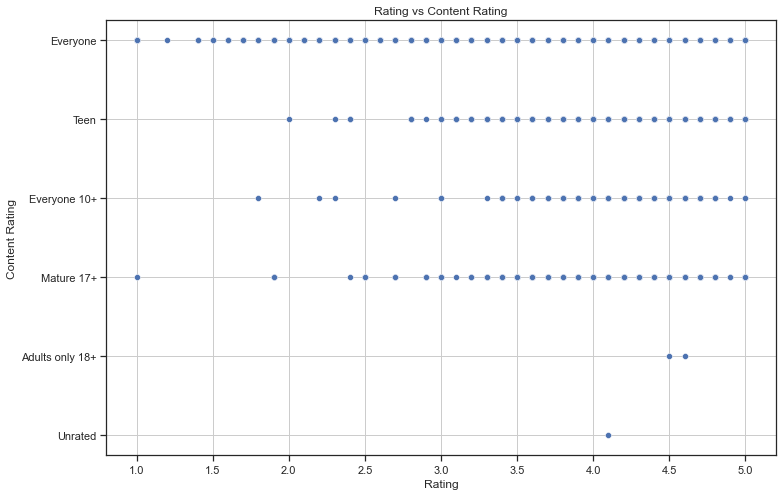

In [27]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.scatterplot(x = 'Rating', y = 'Content Rating', data = data)
plt.grid()
plt.title('Rating vs Content Rating')
plt.show()

> From the preceding plot we observe that apps that are rated for everyone have more ratings compared to the apps that are unrated. Essentially we can argue that some apps are liked better given that apps rated Adults only 18+ and unrated have a rating of at least 3.7 while other apps especially those rated *everyone* rate lower even though they have a higher number of ratings implying more installs

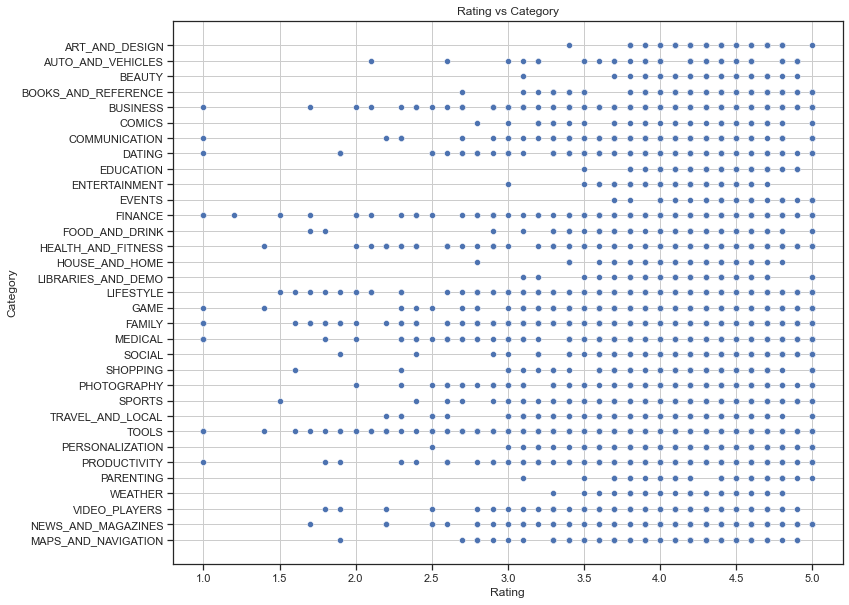

In [28]:
plt.rcParams['figure.figsize'] = [12, 10]
sns.scatterplot(x = 'Rating', y = 'Category', data = data)
plt.grid()
plt.title('Rating vs Category')
plt.show()

> Art and Design apps have generally higher ratings with the lowest rated apps having a rating of about 3.4 with other art and design apps reaching a rating of 5.0

### Data Preprocessing

##### Make a copy of the dataset

In [29]:
inp1 = data.copy()

##### Apply transformation of the Reviews and Installs

In [30]:
#log transform the reviews variable
inp1['Reviews'] = np.log1p(inp1.Reviews)
#Log transform the Installs
inp1['Installs'] = np.log1p(inp1.Installs)

##### Drop the App, Last Updated, Current Ver, and Android Ver columns

In [31]:
inp1 = inp1.drop(['App','Last Updated', 'Current Ver', 'Android Ver'], axis = 1).copy()

#### Create Dummy Category, Genres, and Content Rating

> Type is a string column we also had to obtain its dummies sinnce we ran into a problem during modelling when using it as it is.

In [32]:
inp2 = pd.get_dummies(inp1, columns=['Category', 'Genres', 'Content Rating', 'Type'],
               drop_first=True, prefix=['Category', 'Genres', 'Content Rating', 'Type'])


##### Split the data to train and test sets (df_train and df_test).

In [33]:
df_train, df_test = train_test_split(inp2, test_size=0.30, random_state=42)

##### Separate the dataframes into X_train, y_train, X_test, and y_test.

In [34]:
X_train = df_train.drop('Rating', axis = 1)

X_test = df_test.drop('Rating', axis = 1)


y_train = df_train.Rating


y_test = df_test.Rating

### Model Building

##### Use linear regression as the technique

In [38]:
reg = LinearRegression()
#fit the model
res = reg.fit(X_train, y_train)
#Get predictions on train set

preds = reg.predict(X_train)
#get the R2 on the train set
print("R-Squared score on the train data = ",round(r2_score(y_train, preds),4))

R-Squared score on the train data =  0.1604


##### Make predictions on test set and report R2.

In [39]:
preds = reg.predict(X_test)
#get the R2 on the test set
print("R-Squared score on the test data = ",round(r2_score(y_test, preds),4))

R-Squared score on the test data =  0.1135
